1. Load data and models
2. Generate normalized topic importance measures
3. Coincide with other timeline
4. Test for Granger Causality

# Load cleaned data 

In [18]:
import pandas as pd
df = pd.read_csv('data/sample_5000_clean.csv', index_col="Unnamed: 0")
print(df.shape)
df.head()

(5000, 6)


,Index,date,text,title,week,clean_text
5038,621031,2017-10-26 15:00:54,eBay launches visual search tools that let you...,eBay launches visual search tools that let you...,2017-10-29 00:00:00,ebay launches visual search tools let shop usi...
5039,621032,2017-10-26 00:00:00,Monsanto Attacks Scientists After Studies Show...,Monsanto Attacks Scientists After Studies Show...,2017-10-29 00:00:00,attacks scientists after studies show trouble ...
5040,621035,2017-10-26 14:41:12,"Hard Drive Stats for Q3 2017In Q3 2017, Backbl...",2017 Hard Drive Reliability by Drive Size and ...,2017-10-29 00:00:00,hard drive stats introduced both tb tb hard dr...
5041,621036,2017-10-26 15:27:11,This is part 1 of the “How Unreal Renders a Fr...,How Unreal Renders a Frame,2017-10-29 00:00:00,part how renders frame series access part part...
5042,621423,2017-10-26 16:02:00,Boeing builds towards its first space taxi tes...,Boeing builds towards its first space taxi test,2017-10-29 00:00:00,builds towards first space taxi nasa first nam...


In [19]:
import joblib
lda = joblib.load("models/lda")
tf_vec = joblib.load("models/tfvec")
tf = joblib.load("models/tf")

# Generate Indicators

## LDA

In [20]:
# get topic probabilites
topic_probs = lda.transform(tf)
print(topic_probs.shape)

# cast dates to date type
df.date = pd.to_datetime(df.date)
# Generate frequencies 
freqs = ["Q", "W", "M"]
for freq in freqs:
    df[freq] = df.date.dt.to_period(freq).dt.to_timestamp(freq)
    df[f"{freq}_dummy"] = pd.factorize(df[freq])[0]
    
df.head()

(3000, 15)


,Index,date,text,title,week,clean_text,Q,Q_dummy,W,W_dummy,M,M_dummy
5038,621031,2017-10-26 15:00:54,eBay launches visual search tools that let you...,eBay launches visual search tools that let you...,2017-10-29 00:00:00,ebay launches visual search tools let shop usi...,2017-12-31,0,2017-10-29,0,2017-10-31,0
5039,621032,2017-10-26 00:00:00,Monsanto Attacks Scientists After Studies Show...,Monsanto Attacks Scientists After Studies Show...,2017-10-29 00:00:00,attacks scientists after studies show trouble ...,2017-12-31,0,2017-10-29,0,2017-10-31,0
5040,621035,2017-10-26 14:41:12,"Hard Drive Stats for Q3 2017In Q3 2017, Backbl...",2017 Hard Drive Reliability by Drive Size and ...,2017-10-29 00:00:00,hard drive stats introduced both tb tb hard dr...,2017-12-31,0,2017-10-29,0,2017-10-31,0
5041,621036,2017-10-26 15:27:11,This is part 1 of the “How Unreal Renders a Fr...,How Unreal Renders a Frame,2017-10-29 00:00:00,part how renders frame series access part part...,2017-12-31,0,2017-10-29,0,2017-10-31,0
5042,621423,2017-10-26 16:02:00,Boeing builds towards its first space taxi tes...,Boeing builds towards its first space taxi test,2017-10-29 00:00:00,builds towards first space taxi nasa first nam...,2017-12-31,0,2017-10-29,0,2017-10-31,0


In [45]:
########################
## Data Preprocessing ##
########################

def predict_topics(text, tf, lda):
    vec = tf.transform(text)
    return lda.transform(vec)


# topic weights
df["topics"] = df["text"].apply(lambda x: predict_topics([x], tf_vec, lda))
topics = df["topics"].apply(lambda x: x[0]).apply(pd.Series)
topics.columns = [f"t_{i}" for i in topics.columns.values]

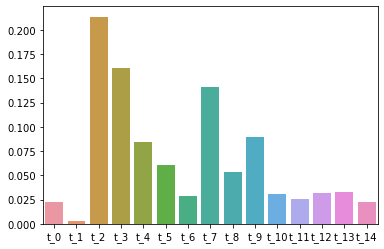

In [46]:
import seaborn
import matplotlib.pyplot as plt
weights = topics.sum() / topics.sum().sum()
seaborn.barplot(weights.index, weights.values)
# plt.savefig(f"results/{run}/topic_importance.png", bbox_inches='tight')
# plt.savefig(f"results/{run}/topic_importance.pdf", bbox_inches='tight')
# plt.close()

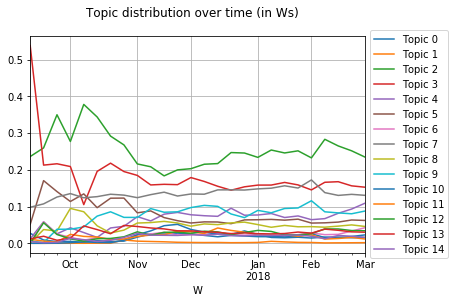

In [47]:
date_unit = "W"
ewmspan=3
ddf = topics.join(df[date_unit])
fig, ax = plt.subplots()
topics.join(df[date_unit]).groupby(date_unit)[topics.columns.values].mean().ewm(span=ewmspan).mean().plot(ax=ax)
ax.legend([f"Topic {i}" for i in range(lda.n_components)], loc='center left', bbox_to_anchor=(1, 0.5), )
ax.set_xlabel(f"{date_unit}".title())
plt.suptitle(f"Topic distribution over time (in {date_unit}s)")
plt.grid()
# plt.savefig(f"results/{run}/topic_timeline.png", bbox_inches='tight')
# plt.savefig(f"results/{run}/topic_timeline.pdf", bbox_inches='tight')
# plt.close()


# Match with other Time series

In [95]:
ts = pd.read_csv("data/ETH-USD.tsv", sep="\t")
ts["date"] = pd.to_datetime(ts['time'], unit="s")
ts["week"] = ts.date.dt.to_period("W").dt.to_timestamp("W")

ts.head()

,time,low,high,open,close,volume,date,week
0,1497196800,333.43,339.66,336.58,338.73,22887.57,2017-06-11 16:00:00,2017-06-11
1,1497200400,338.36,342.49,338.73,342.16,17959.55,2017-06-11 17:00:00,2017-06-11
2,1497204000,341.78,348.53,342.16,348.43,28182.27,2017-06-11 18:00:00,2017-06-11
3,1497207600,343.80,348.59,348.43,346.23,23394.43,2017-06-11 19:00:00,2017-06-11
4,1497211200,345.62,348.62,346.23,347.29,17382.68,2017-06-11 20:00:00,2017-06-11


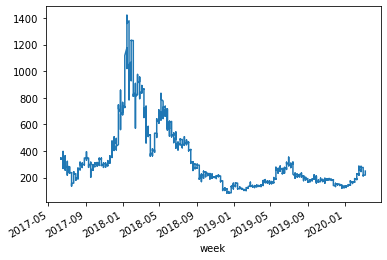

In [96]:
ts.set_index('week')["close"].plot()

In [97]:
topics_w = topics.join(df.week)
joined = topics_w.groupby("week").t_9.agg(["mean"]).join(ts.groupby('week')['close'].last(), rsuffix="_")
joined.head()

,mean,close
week,,
2017-09-10,0.006079,299.21
2017-09-17,0.000077,258.40
2017-09-24,0.065526,282.60
2017-10-01,0.038731,303.95
2017-10-08,0.050292,309.49


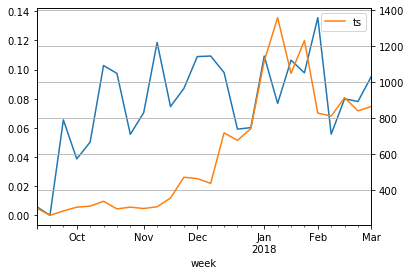

In [98]:
ax = joined['mean'].plot(label="lda")
joined['close'].plot(ax=ax, secondary_y=True, label="ts")
plt.legend()
plt.grid()

# Test for Granger Causality

In [99]:
from statsmodels.tsa.stattools import grangercausalitytests

gcres = grangercausalitytests(joined.values, maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6211  , p=0.2162  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=1.8421  , p=0.1747  , df=1
likelihood ratio test: chi2=1.7774  , p=0.1825  , df=1
parameter F test:         F=1.6211  , p=0.2162  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8779  , p=0.4319  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=2.2178  , p=0.3299  , df=2
likelihood ratio test: chi2=2.1212  , p=0.3462  , df=2
parameter F test:         F=0.8779  , p=0.4319  , df_denom=19, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5349  , p=0.6650  , df_denom=16, df_num=3
ssr based chi2 test:   chi2=2.3067  , p=0.5112  , df=3
likelihood ratio test: chi2=2.1983  , p=0.5323  , df=3
parameter F test:         F=0.5349  , p=0.6650  , df_denom=16, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8079  , p=0.1875  , df_d